In [6]:
# standard python utilities
import os
from os.path import join, basename,dirname
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
# import rasterio

# mapping utilities
# import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator

import flopy
import flopy.utils.binaryfile as bf


In [7]:
git_dir = os.getcwd()
while basename(git_dir) != 'GitHub':
    git_dir = dirname(git_dir)
usr_dir = os.getcwd()
while basename(usr_dir) != 'Users':
    temp = basename(usr_dir)
    usr_dir = dirname(usr_dir)
usr_dir += '/'+temp

py_dir = git_dir +'/CosumnesRiverRecharge/python_utilities/'
## Set up directory referencing
# Package data
gwfm_dir = usr_dir+'/Box/research_cosumnes/GWFlowModel/'
proj_dir = gwfm_dir+'Stream_seepage/'
dat_dir = proj_dir+'Stream_level_data/'
fig_dir = proj_dir+'/Streambed_seepage/figures/'
gwfm_dir


'C:\\Users/ajcalder/Box/research_cosumnes/GWFlowModel/'

In [10]:
# run_dir = 'C://WRDAPP/GWFlowModel'
# run_dir = 'F://WRDAPP/GWFlowModel'
# loadpth = run_dir +'/Cosumnes/'




loadpth =  'C:/WRDAPP/GWFlowModel/Cosumnes/Stream_seepage'
model_ws = loadpth+'/data'

m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
                                exe_name='mf-owhm.exe', version='mfnwt')
# m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
#                                 exe_name='mf2005.exe', version='mf2005')

In [137]:
events = pd.read_csv(dat_dir+'event_dates.csv',index_col=0,parse_dates=['start','end']).dropna(axis=0)

events['length'] = events.end-events.start



In [11]:
strt_date = pd.to_datetime(m.dis.start_datetime)
# end_date = (strt_date + pd.Series((m.dis.nper-1)*15).astype('timedelta64[m]'))[0] # SS
end_date = (strt_date + pd.Series((m.dis.nper)*15).astype('timedelta64[m]'))[0]

dates_per = pd.date_range(strt_date, end_date, freq = '15min')
dates_stps = pd.date_range(strt_date, end_date, freq = '5min')[:-1]


In [12]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
times = hdobj.get_times()

# kstp = np.append([0], np.tile(np.arange(0,3), m.dis.nper)) # with SS period
# kper = np.repeat(np.arange(0,m.dis.nper),m.dis.nstp)

kstp = np.tile(np.arange(0,3), m.dis.nper)
kper = np.repeat(np.arange(0,m.dis.nper),m.dis.nstp)

kstpkper = list(zip(kstp,kper))

dt_ref = pd.DataFrame(dates_stps, columns=['dt'])
dt_ref['kstpkper'] = kstpkper
# dt_ref

## Sensor data and XS data

In [13]:
df = pd.read_csv(dat_dir+'instream_sensor_latlong.csv',comment='#', engine='python')
df['id_num'] = df.Sensor.str.extract(pat=r'(\d+)').astype(float)
rm = df[df.Type=='Level']
rm_sp = gpd.GeoDataFrame(rm, geometry=gpd.points_from_xy(rm.Longitude,rm.Latitude))
rm_sp.crs = 'epsg:4326'
rm_sp = rm_sp.to_crs('epsg:32610')

rm_teichert = rm_sp[rm_sp.id_num>3]


rm_xs = gpd.read_file(proj_dir+ 'rm_xs/rm_xs.shp')

In [14]:
# XS are every 100 m
xs_all = pd.read_csv(dat_dir+'XS_point_elevations.csv',index_col=0)
xs_all = gpd.GeoDataFrame(xs_all,geometry = gpd.points_from_xy(xs_all.Easting,xs_all.Northing), crs='epsg:32610')


In [72]:
XSg = pd.read_csv(join(model_ws,'04_XSg_filled.csv'))

# overwrite SFR segment/reach input relevant to seepage
# sensor_dict = pd.read_csv(join(model_ws, 'sensor_xs_dict.csv'), index_col=0)
# XS_params = sensor_dict.join(params.set_index('Sensor'), on='Sensor')

In [16]:
rm_teichert['Easting'] = rm_teichert.geometry.x
rm_teichert['Northing'] = rm_teichert.geometry.y
rm_poly = rm_teichert.copy()
# buffer sensor points for joining
rm_poly.geometry = rm_poly.geometry.buffer(50)
# correspond XS to sensors
rm_elev = gpd.sjoin(xs_all, rm_poly, how='inner',lsuffix='xs', rsuffix='rm')

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:786: DeprecationWarning: An exception was ignored while fetc

In [81]:
rm_elev['dist'] = np.sqrt((rm_elev.Easting_xs - rm_elev.Easting_rm)**2 + (rm_elev.Northing_xs - rm_elev.Northing_rm)**2)
mindists = rm_elev.groupby('xs_num').min().dist
# rm_elev.columns
rm_elev_final = rm_elev.set_index(['xs_num','dist']).loc[list(zip(mindists.index, mindists.values))]
# join with XS minimum and slope data
rm_elev_final = rm_elev_final.join(XSg.set_index('xs_num')[['z_m_min_cln','slope']])

# field data with measurements
field = pd.read_excel(dat_dir+'Field_measurements.xlsx',sheet_name='Summarized').rename(columns={'Site':'Sensor'})
rm_elev_final = rm_elev_final.join(field.set_index('Sensor'),on='Sensor')

# rm_elev_final['height_above_thalweg_m'] = rm_elev_final.z_m - rm_elev_final.z_m_min
rm_elev_final['height_above_thalweg_m'] = rm_elev_final['Height above thalweg (ft)']  * 0.3048
# sensor height above thalweg
rm_elev_final['sensor_height_m'] = rm_elev_final.z_m_min_cln + rm_elev_final.height_above_thalweg_m

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_12924\2549232970.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  mindists = rm_elev.groupby('xs_num').min().dist


In [18]:
FLD = pd.read_csv(dat_dir+'FLD.csv', parse_dates=['DATE TIME'], na_values='---')
ANU = pd.read_csv(dat_dir+'ANU.csv', parse_dates=['DATE TIME'], na_values='---')


In [19]:
baro = pd.concat((FLD,ANU)).pivot(columns='STATION_ID',values='VALUE',index='DATE TIME')
# resample to hour for consistent units
baro = baro.resample('H').mean()
# convert from inches to meters
baro = (baro/12) * 0.3048
baro = baro.resample('15min').ffill()

In [20]:
lvl = pd.read_csv(dat_dir+'Stream_level_m_temp_C_long.csv', parse_dates=['dt'])
lvl = lvl[lvl.param=='LEVEL']
# lvl.loc[lvl.value>9,'value'] -= 9.5
# lvl = lv.pivot(columns = 'site_nam',values='value', index='dt')

# adjust level data for uniform baro pressure
lvl = lvl.pivot(columns='site_nam',values='value',index='dt')
lvl.loc[:,(lvl.mean()>9.5)] -= 9.5
lvl = lvl.melt(ignore_index=False).dropna()

# join with barometric pressure by date
lvl = lvl.join(baro, on='dt')
lvl['lvl_adj'] = lvl.value - lvl.FLD

In [82]:
# params = pd.read_csv(model_ws+'/instream_sensor_params.csv',comment='#',engine='python')
params = pd.read_csv(model_ws+'/teichert_params.csv',comment='#',engine='python')

str_obs = lvl.join(rm_elev_final[['height_above_thalweg_m','sensor_height_m','Sensor']].set_index('Sensor'), on='site_nam')
str_obs = str_obs.dropna(subset='height_above_thalweg_m')
# calculate stage with height above thalweg
str_obs['depth'] = str_obs.lvl_adj + str_obs.height_above_thalweg_m
str_obs['stage'] = str_obs.lvl_adj + str_obs.sensor_height_m

# need to calibrate offset slightly manually - shouldn't adjust observed to simulated as simulated baseline changes
# stage = lvl.join(params[['Sensor','stg_offset']].set_index('Sensor'), on='site_nam')
# # stage = stage.dropna(subset='stg_offset')
# stage['stage_m'] = stage.lvl_adj + stage.stg_offset

# need to skip first six hours for model burn in (initial low flows)
str_obs_per = str_obs[(str_obs.index>dt_ref.dt.min()+pd.DateOffset(hours=6))&(str_obs.index<dt_ref.dt.max())]

In [22]:
sfr_dir = gwfm_dir+'/SFR_data/'
# grid_sfr = gpd.read_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')
# m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')


In [23]:
mcc_d = pd.read_csv(sfr_dir+'MCC_flow_obs_all.csv', parse_dates = ['DATE TIME'], index_col='DATE TIME')
mcc_d = mcc_d[(mcc_d.index>strt_date)&(mcc_d.index<end_date)]


In [24]:
grid_sfr = pd.DataFrame().from_records(m.sfr.reach_data).rename(columns={'i':'row','j':'column'})
grid_sfr[['row','column']] += 1 # convert to 1 based to match with SFR output
pd_sfr = pd.DataFrame(grid_sfr.set_index(['row','column'])[['rchlen','strtop']])
pd_sfr['Total distance (m)'] = pd_sfr['rchlen'].cumsum()

def clean_sfr_df(model_ws):
    sfrout = flopy.utils.SfrFile(model_ws+'/MF.sfr.out')
    sfrdf = sfrout.get_dataframe()
    sfrdf = sfrdf.join(dt_ref.set_index('kstpkper'), on='kstpkper')
    cmm2cfs = 1/((0.3048**3)*60) # cubic meters per minute to cfs

#     sfrdf_plot = pd_sfr.join(sfrdf.set_index(['row','column']),on=['row','column'],how='inner',lsuffix='_all')
    sfrdf_plot = sfrdf.join(pd_sfr ,on=['row','column'],how='inner',lsuffix='_all')
    # dependent on number of time steps
    sfrdf_plot['Qin_cfs'] = sfrdf_plot.Qin * cmm2cfs
    sfrdf_plot['Qout_cfs'] = sfrdf_plot.Qout * cmm2cfs
    sfrdf_plot['Qaquifer_cfs'] = sfrdf_plot.Qaquifer * cmm2cfs
    sfrdf_plot = sfrdf_plot.set_index('dt')
    return(sfrdf_plot)



In [25]:
sfrdf_plot = clean_sfr_df(model_ws)
# gage_file = glob.glob(model_ws+'/*.go')
# gage_file[0]

In [26]:
# mcc_plt = mcc_out.join(mcc_d)

# fig,ax=plt.subplots(figsize=(8,4))
# mcc_plt.plot(y='flow_sim_cfs',label='MCC Simulated',ax=ax)

# mcc_plt.plot(y='flow_cfs',label='MCC Observed',ax=ax, linestyle='--')

# mb.plot(y='flow_cfs',label= 'MB Observed', ax=ax)
# under simulating flow most likely because we don't have any runoff
# adding uzf to remove excess recharge to stream would most likely bring up the peak flows

In [27]:
def read_sfr_gage(xs_num):
    gagenam = model_ws+'/MF_gage_' + str(xs_num) + '.go'
    gage = pd.read_csv(gagenam,skiprows=1, delimiter = '\s+', engine='python')
    cols = gage.columns[1:]

    gage = gage.dropna(axis=1)
    gage.columns = cols
    cmm2cfs = 1/((0.3048**3)*60) # cubic meters per minute to cfs
    # convert from m3/day to cfs
    gage['Stream_leakage'] = gage['Conductance']* gage['HeadDiff'] /(0.3048**3)/86400
    gage['Stream_leakage_cfs'] = gage['Stream_leakage'] * cmm2cfs
    gage['Flow_cfs']  = gage['Flow'] * cmm2cfs
    gage['Time'] = strt_date + gage.Time.values.astype('timedelta64[m]')
    gage = gage.set_index('Time')
    return(gage)


<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_12924\3313131711.py:3: DeprecationWarning: invalid escape sequence \s
  gage = pd.read_csv(gagenam,skiprows=1, delimiter = '\s+', engine='python')


In [83]:
str_obs_cln = str_obs[str_obs.lvl_adj>0.2].pivot(columns='site_nam',values='lvl_adj').dropna(axis=0)
# stage_cln

<AxesSubplot:xlabel='dt'>

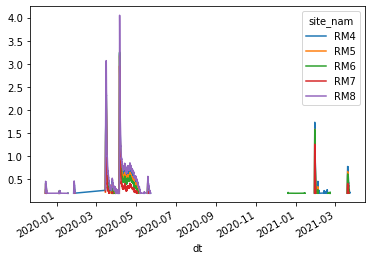

In [84]:
str_obs[str_obs.lvl_adj>0.2].pivot(columns='site_nam',values='lvl_adj').plot()

In [164]:
df.max()
df
# plt.vlines(df.idxmax(axis=0).values,ymin=0, ymax = 1.5)
# plt.legend()

site_nam                  RM4       RM5       RM6       RM7
dt                                                         
2021-03-19 00:15:00  0.724060  1.171860  0.584660  0.706060
2021-03-19 00:30:00  0.724060  1.173760  0.586660  0.708060
2021-03-19 00:45:00  0.722060  1.173260  0.584660  0.708060
2021-03-19 01:00:00  0.724314  1.173914  0.584914  0.708314
2021-03-19 01:15:00  0.724314  1.174214  0.584914  0.708314
...                       ...       ...       ...       ...
2021-03-23 22:30:00  0.790600  1.135800  0.540200  0.689600
2021-03-23 22:45:00  0.790600  1.135300  0.540200  0.685600
2021-03-23 23:00:00  0.792600  1.134800  0.537200  0.689600
2021-03-23 23:15:00  0.789600  1.133700  0.536200  0.685600
2021-03-23 23:30:00  0.787600  1.132600  0.533200  0.683600

[470 rows x 4 columns]

site_nam
RM4   2020-05-19 07:15:00
RM5   2020-05-19 09:00:00
RM6   2020-05-19 09:30:00
RM7   2020-05-19 09:00:00
RM8   2020-05-19 07:45:00
dtype: datetime64[ns]
site_nam
RM4   2020-05-18 17:00:00
RM5   2020-05-18 07:45:00
RM6   2020-05-18 20:45:00
RM7   2020-05-18 17:00:00
RM8   2020-05-18 20:15:00
dtype: datetime64[ns]


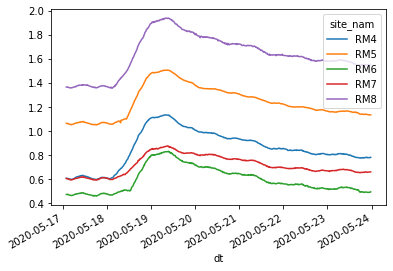

In [177]:
def d_plt(str_obs, num):
    strt_date = events.start[num]
    end_date = events.end[num]
    str_obs_per = str_obs[(str_obs.index>strt_date)&(str_obs.index<end_date)]
    df = str_obs_per[['site_nam','depth']].pivot_table(values='depth',index='dt',columns='site_nam')
    df.plot()
    print(df.idxmax())
#     print(df.diff().idxmax())

    return(df)
df = d_plt(str_obs, 5)


the april 6 event is one with clear 15 min staggers between each event  
looking at calculate change in stage doesn't work well because the largest change isn't always the point where the peak starts
I can't accurately apply the method by Niswonger because the timing is too coarse at 15min to pre-calculate the flood wave velocity accurately, but there is still valuable information on the shape of the flood waves (volume of flow is dependent on depth, change in volume between sections is dependent on seepage losses, the time it takes small waves to arrive is dependent on seepage, roughness, slope. 
On a larger scale I could review the rate of flow traveling between Michigan Bar, MCC, TWC, LWC

In [ ]:
# skip past first 4 hours for observations to allow for burn in
fig,ax = plt.subplots(5,1, figsize=(10,10), sharex=True)
for n in np.arange(0,5):
    ax_n = ax[n]
# n=4 # have 0 through 4
#     print(rm_xs[['Sensor','iseg']].iloc[n])
    # fig,ax=plt.subplots(figsize=(8,6))
    str_obs_per..iloc[3*4*4:].plot(y='depth', ax=ax_n, label='Observed Stage')
    ax_n.set_title(rm_xs[['Sensor']].iloc[n].values[0]+' - '+rm_xs[['iseg']].iloc[n].values[0].astype(str))
# stage_m.loc[stage_m.site_nam==rm_xs.Sensor[n]].iloc[3*4*4:].plot(y='lvl_adj', ax=ax, label='Level Adjusted')
fig.tight_layout()
# ax.set_xlim()

Calibration should be done with change in stage rather than absolute values. I can create an offset to align values better as well. The first few XS seems to represent the observations well, but it appears that there may be some baseflow prevent a decline in flow downstream, starting at XS25 where the simulated stage appears to oscillate following a decline. When I check heads the first time there was a mound causing some baseflow but even after correcting the higher streamflow seems to stay. It starts with the flow leaving XS 21 with oscillations (1000 to 1500 cmm)

This issue only occurs with the UZF package

In [30]:
# 20 is the problem
# n=2
# fig,ax = plt.subplots(3,1, figsize=(12,6), sharex=True)
# sfrdf_plot[sfrdf_plot.segment==n].plot(y=['Qin','Qout'], ax=ax[0])
# sfrdf_plot[sfrdf_plot.segment==n].plot(y='Qaquifer', ax=ax[1])

# sfrdf_plot[sfrdf_plot.segment==n].plot(y='stage', ax=ax[2])
# # sfrdf_plot[sfrdf_plot.segment==n].plot(y=['Qovr','Qprecip','Qet']) # 0 as expected
# sfrdf_plot.columns

# fig.tight_layout()
# the listing file confirmed Segment 20 was having non-convergence issues

the obs data set for UCODE will either be absolute observed stage or change in stage. And UCODE can read the absolute stage directly from the gage file, but would need an additional post-processor script to write out a change in stage file.

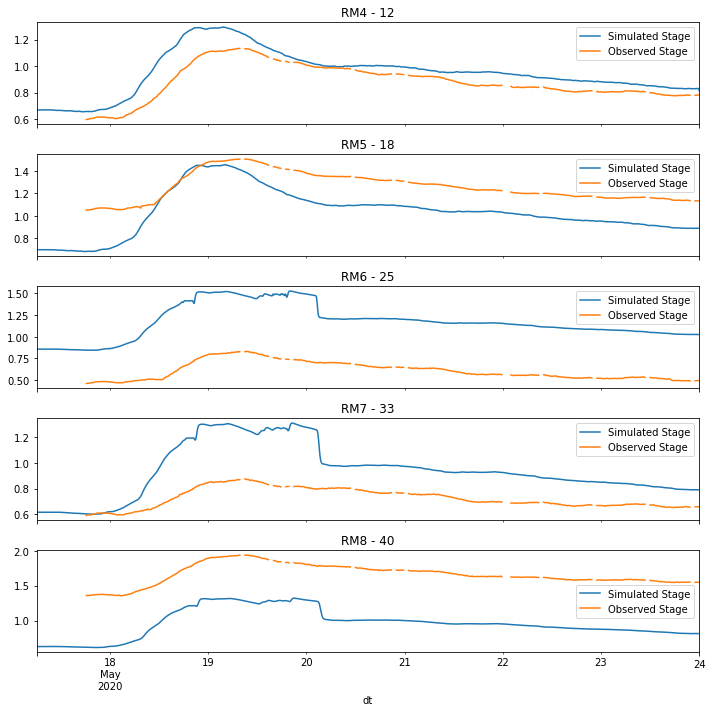

In [121]:
# skip past first 4 hours for observations to allow for burn in
fig,ax = plt.subplots(5,1, figsize=(10,10), sharex=True)
for n in np.arange(0,5):
    ax_n = ax[n]
# n=4 # have 0 through 4
#     print(rm_xs[['Sensor','iseg']].iloc[n])
    # fig,ax=plt.subplots(figsize=(8,6))
    read_sfr_gage(rm_xs.iseg[n]).iloc[3*4*6:].plot(y='Depth', ax=ax_n, label='Simulated Stage')
    str_obs_per.loc[str_obs_per.site_nam==rm_xs.Sensor[n]].iloc[3*4*4:].plot(y='depth', ax=ax_n, label='Observed Stage')
    ax_n.set_title(rm_xs[['Sensor']].iloc[n].values[0]+' - '+rm_xs[['iseg']].iloc[n].values[0].astype(str))
# stage_m.loc[stage_m.site_nam==rm_xs.Sensor[n]].iloc[3*4*4:].plot(y='lvl_adj', ax=ax, label='Level Adjusted')
fig.tight_layout()
# ax.set_xlim()

<AxesSubplot:xlabel='dt'>

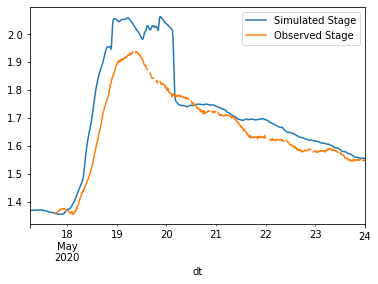

In [118]:
# for n in 

fig,ax_n = plt.subplots()
# read gage file
s = read_sfr_gage(rm_xs.iseg[n]).iloc[3*4*6:]
# load observation of the same period
o = str_obs_per.loc[str_obs_per.site_nam==rm_xs.Sensor[n]].iloc[3*4*4:]
# calculate the difference between the pre event depth
pre_diff = o[:int(o.shape[0]*0.25)].min()['depth'] - s[:int(s.shape[0]*0.25)].min()['Depth']
# correct the depth
s['Depth'] += pre_diff
s.plot(y='Depth', ax=ax_n, label='Simulated Stage')
o.plot(y='depth', ax=ax_n, label='Observed Stage')



It generally seems that the baseline offset is causing a large amount of the error and is causing UCODE to attempt to offset in the wrong direction at times, for example if RM4 observations start above the simulation but the peaks match then there will be less interest in matching the lower flows. I added the stream offset into the calibration mix but I didn't think that the offset needs to be applied to the simulation, rather than post-process the output. As the HK/n is changed the baseline stream stage changes which ruins the offset. I need to build an offset into the simulation, by adjusting the stream bottom elevation. This is probably a good reason to switch to changes in stream level calibration. The stream bot is used in the stage calculation, but I don't really want to mess with this because it impacts the slope calculation.

I need to post-process the output then read the adjusted depth. The other major factor of depth is the cross-section elevations which Niswonger assumed was constant and Shanafield had constant canal trapezoids. By auto-correcting the pre-event depth I'm assuming that simulation should match observation but there is an offset in the observation base height and that once fixed the cross-section  matches.

It is also necessary to address the roughness which if decreased will decrease the flood stage and increase when it arrives. Need to prove that seepage is statistically more important than roughness.

In [321]:

# need save flow_obs file for UCODE obs.data
# create unique obsnam
stage_m['dt_nam'] = stage_m.index.astype(str).str.slice(5,-3).str.replace('-| |:','_', regex=True)
stage_m['obs_nam'] = stage_m['site_nam']+'_'+stage_m['dt_nam']
stage_m = stage_m.dropna(subset='stage_m')
#  ObsName GroupName ObsValue
flow_arr = stage_m[['obs_nam','site_nam','stage_m']].values

cols_out = ['ObsName','GroupName','ObsValue']

header = 'BEGIN Observation_Data Table\n'+\
    'NROW= '+str(len(flow_arr))+' NCOL= '+str(len(cols_out))+' COLUMNLABELS\n'+\
    ' '.join(cols_out)

footer = 'End Observation_Data'
# get array of just strings
# pull out observed value and name of obs
np.savetxt(model_ws+'/flow_obs.dat', flow_arr,
           fmt='%s', header = header, footer = footer, comments = '' )

# set up .jif file for 4 gage files
# if there is not a corresponding obs_nam for a simulated value you must use the filler 'dum'

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_13380\1532982922.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage_m['dt_nam'] = stage_m.index.astype(str).str.slice(5,-3).str.replace('-| |:','_', regex=True)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_13380\1532982922.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage_m['obs_nam'] = stage_m['site_nam']+'_'+stage_m['dt_nam']


In [257]:
for n in np.arange(0,5):
    gag_out = read_sfr_gage(rm_xs.iseg[n])[['Stage']]
    gag_out = gag_out.join(stage_m.loc[stage_m.site_nam==rm_xs.Sensor[n]][['obs_nam']])
    gag_out.loc[gag_out.obs_nam.isna(),'obs_nam'] = 'dum'
    gag_obs_out = gag_out.obs_nam.values


    # 1st number is lines to skip, 2nd is column to read, third is number of values
    # for gage file 2 is stage (m), 3 is flow (cubic meters per minute), 4 is depth
    # where there is no obs_nam place 'dum'
    header = 'jif @\nStandardFile 2 4 '+str(len(gag_obs_out))

    np.savetxt(model_ws+'/MF_gage_'+str(rm_xs.iseg[n])+'.go.jif', gag_obs_out,
               fmt='%s', header = header, comments = '' )


### Plot stream discretization

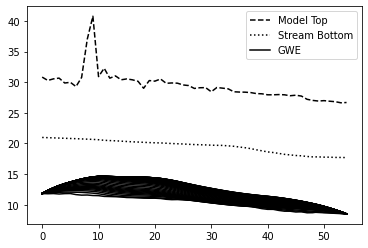

In [33]:
plt.plot(m.dis.top.array[0],label='Model Top', ls='--',color='black')
plt.plot(m.sfr.reach_data.strtop-m.sfr.reach_data.strthick, label= 'Stream Bottom', ls=':',color='black')

# spd_hd = dt_ref[dt_ref.dt == '2020-05-21'].kstpkper.values[0]
# head = hdobj.get_data(spd_hd)[0][0]

for t in dt_ref[0::12*4].dt: # every hour (12)
    spd_hd = dt_ref[dt_ref.dt == t].kstpkper.values[0]
    head = hdobj.get_data(spd_hd)[0][0]

    plt.plot(head, color='black')
plt.plot(head,label = 'GWE',  color='black')

plt.legend()